## Machine Learning
### Project

#### Machine Generated Abstract Art (VAE Model to Create Image Data From Existing Art Images)

#### Amro Shanshal, Arpit Parihar, Rose Ro, Yue Wu

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import the 32x32 images from the shared drive

In [21]:
from matplotlib import pyplot as plt
import os
from os import listdir
from PIL import Image
import sys
import glob
from matplotlib import image

# train discriminator
def load_images ():
  X = []
  data_path = '/content/drive/Shareddrives/Machine Learning Final Project - GANs/GAN Training Data/Abstract_gallery_32/'

  imagesList = listdir(data_path)
  for image in imagesList:
    img = np.asarray(Image.open(data_path + image))
    X.append(img)

  return X

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

In [23]:
Train_data=np.array(load_images())

In [24]:
Train_data

array([[[[237, 188, 147],
         [233, 185, 147],
         [231, 188, 154],
         ...,
         [251, 180, 136],
         [251, 177, 140],
         [248, 171, 141]],

        [[246, 189, 162],
         [242, 186, 161],
         [239, 189, 166],
         ...,
         [250, 182, 143],
         [250, 179, 149],
         [247, 175, 150]],

        [[255, 193, 171],
         [252, 191, 172],
         [249, 192, 175],
         ...,
         [247, 188, 156],
         [248, 186, 163],
         [245, 182, 164]],

        ...,

        [[255, 210, 122],
         [255, 210, 125],
         [255, 211, 129],
         ...,
         [254, 226, 117],
         [252, 220, 111],
         [249, 215, 105]],

        [[253, 209, 102],
         [255, 212, 107],
         [255, 213, 114],
         ...,
         [253, 227, 142],
         [251, 223, 149],
         [249, 220, 152]],

        [[240, 208,  89],
         [243, 210,  95],
         [247, 213, 103],
         ...,
         [237, 212, 146],
        

#### Build the encoder and decoder

In [25]:
"""
  Convolutional structure for the encoder net
"""

encoder = tf.keras.Sequential([
    layers.Conv2D(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=512, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Flatten()
])

"""
  DeConv structure for the decoder net
"""

decoder = tf.keras.Sequential([
    layers.Dense(2048),
    layers.Reshape(target_shape=(4, 4, 128), input_shape=(None, 1024)),
    layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=3  , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
])

It’s important to notice that the convolution layer used in decoder is Conv2DTranspose which works by doing inverse transformation of the standard Conv2D layer

Also, notice that the last Conv2DTranspose layer acts as the output of the decoder, it upsamples as we want to reshape back to the original image dimension 

In [26]:
batch_size = 250

x = tf.placeholder(tf.float32, shape=[batch_size, 32, 32, 3])

encoded = encoder(x)

mean = layers.Dense(1024, tf.nn.softplus)(encoded)
sigma = layers.Dense(1024, tf.nn.relu)(encoded)

z = mean + tf.multiply(tf.sqrt(tf.exp(sigma)),
                       tf.random_normal(shape=(batch_size, 1024)))

x_reco = decoder(z)

#### Calculate the cost by adding resconstruction term to KL Divergence

In [27]:
reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(
    layers.Flatten()(x_reco), scale_identity_multiplier=0.05).log_prob(layers.Flatten()(x)))

kl_divergence = tf.reduce_sum(tf.keras.metrics.kullback_leibler_divergence(x, x_reco), axis=[1, 2])

cost = tf.reduce_mean(reconstruction_term + kl_divergence)

Here, the reconstruction loss term would encourage the model to learn the important latent features, needed to correctly reconstruct image similar to original image. While the KL-divergence-loss term would ensure that the learned distribution is similar to the true distribution (a standard normal distribution).

Also, the scale_identity_multiplier parameter helps to keep the variance low and also provides a numeric value to make this VAE more effective, since low varience means more pronounced images

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

#### Add noise to the original data just to show that VAEs are typically used for denoising images and constructing them to look similar to "original" images. 

In [29]:
noise = 0.3
train_noise = Train_data + noise * np.random.normal(0, 1, size=Train_data.shape)
test_noise = Train_data + noise * np.random.normal(0, 1, size=Train_data.shape)

train_noise = np.clip(train_noise, 0, 1)
X_train=Train_data

#### Run the model 

In [30]:
runs = 1500
n_minibatches = int(X_train.shape[0] / batch_size)

print("Number of minibatches: ", n_minibatches)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(runs):
    pbar = tf.contrib.keras.utils.Progbar(n_minibatches)
    for i in range(n_minibatches):
        
        x_batch = X_train[i*batch_size:(i+1)*batch_size]/255.
        cost_, _ = sess.run((cost, optimizer), feed_dict={x: x_batch})

        pbar.add(1,[("cost",cost_)])

Number of minibatches:  11


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


11/11 [==============================] - 0s 30ms/step - cost: 391031.5096


#### Juxstapose the output and original images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


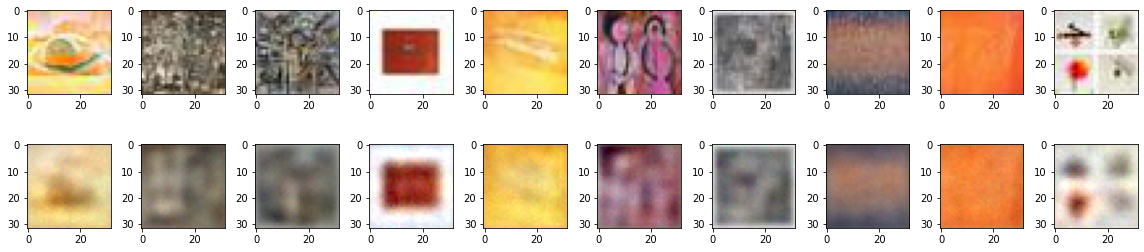

In [31]:
import matplotlib.pyplot as plt
import numpy as np

n_rec = 10

x_batch = X_train[0:batch_size]

plt.figure(figsize=(n_rec+6,4))

pred_img = sess.run(x_reco, feed_dict={x: x_batch})
pred_img = pred_img.reshape(batch_size, 32, 32, 3)
pred_img = pred_img.astype(np.int32)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i])

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()
